<a href="https://colab.research.google.com/github/saman-nia/Deep-Learning-for-Dimensionality-Reduction/blob/master/Text%20Documents%20Dimensionality%20Reduction/K_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Saman Paidar Nia

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

In [0]:
# Import libraries.
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
#-----------------------------------------------------------
import numpy
import warnings
import math
import scipy
import pandas
#-----------------------------------------------------------
from scipy.spatial.distance import squareform, pdist
from math import sqrt
from IPython.display import clear_output
#------------------------------------------------------------
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn import cluster
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise
from sklearn.neighbors import NearestNeighbors
from sklearn import svm
from sklearn import metrics
#------------------------------------------------------------
import matplotlib.pyplot as plt
from tqdm import tqdm
import difflib
import operator
import random
#------------------------------------------------------------
warnings.filterwarnings('ignore')

In [3]:
print('Version of Tensorflow: ', tf.__version__)

Version of Tensorflow:  2.0.0-alpha0


In [0]:
# Compute pairwise distances between observations in n-dimensional space.
class Similarity_Graph:
  def get_matrix(self, data, similar_method):
    X = preprocessing.normalize(data, norm='l2', axis=0)
    X = squareform(pdist(X, str(similar_method)))
    return X

In [0]:
class Similarity_Dataset_Iterator():
  def __init__(self, data, labels, similarity, similarity_method):
    self.data = data
    self.labels = labels
    self.similarity_method = similarity_method
    self.matrix = Similarity_Graph.get_matrix(self, data=self.data,
                                              similar_method=self.similarity_method)
    self.data_size = self.matrix.shape[0]
    self.current_index = 0
  def next_batch(self, num):
    data=self.matrix.transpose()
    labels=self.labels
    idx = numpy.arange(0, len(data))
    numpy.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return data_shuffle, labels_shuffle
  def whole_dataset(self):
    return (self.matrix.transpose(), self.labels)

In [0]:
#  Load the 20 newsgroups dataset and transform it into tf-idf vectors.
def read_NewsGroup_data(similarity, similarity_method, categories_NG):
  import logging
  from optparse import OptionParser
  import sys
  # Display progress logs on stdout
  logging.basicConfig(level=logging.INFO,
                      format='%(asctime)s %(levelname)s %(message)s')
  # parse commandline arguments
  op = OptionParser()  
  op.add_option("--no-idf",
                action="store_false", dest="use_idf", default=True,
                help="Disable Inverse Document Frequency feature weighting.")  
  op.add_option("--n-features", type=int, default=10000,
                help="Maximum number of features (dimensions)"
                   " to extract from text.")
  def is_interactive():
      return not hasattr(sys.modules['__main__'], '__file__')
  # work-around for Jupyter notebook and IPython console
  argv = [] if is_interactive() else sys.argv[1:]
  (opts, args) = op.parse_args(argv)
  if len(args) > 0:
      op.error("this script takes no arguments.")
      sys.exit(1)
  if type(categories_NG) == list and not categories_NG:
    categories_NG = ['comp.graphics','rec.sport.baseball','talk.politics.guns']      
  elif type(categories_NG) != list:
    categories_NG = None      
  _n_samples = len(categories_NG) * 200  
  vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                               min_df=2, stop_words='english',
                               use_idf=opts.use_idf)    
  trian_set = fetch_20newsgroups(subset='all', categories=categories_NG,
                                 shuffle=True, random_state=42)
  data_trian_set = vectorizer.fit_transform(trian_set.data)
  X = data_trian_set.toarray()
  y = trian_set.target
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=42)    
  X_train = X_train[:_n_samples]
  y_train = y_train[:_n_samples]
  X_test = X_test[:_n_samples]
  y_test = y_test[:_n_samples]
  Similarity_X = Similarity_Dataset_Iterator(X_train, y_train, similarity,
                                             similarity_method)    
  return (X_train, y_train, X_test, y_test, categories_NG, Similarity_X)

In [0]:
list_20groups = ['alt.atheism','comp.graphics','comp.os.ms-windows.misc',
                 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware',
                 'comp.windows.x','misc.forsale','rec.autos','rec.motorcycles',
                 'rec.sport.baseball','rec.sport.hockey','sci.crypt',
                 'sci.electronics','sci.med','sci.space','soc.religion.christian',
                 'talk.politics.guns','talk.politics.mideast',
                 'talk.politics.misc','talk.religion.misc']

In [0]:
def list_groups():
  for jj in range(len(list_20groups)):
    print('{:d} : {}'.format(jj+1, list_20groups[jj]))
  print('\n')

In [9]:
list_groups()
categories_NG = []
n_groups = 0
count_run = False
while True:
  if count_run == False:
    count_run = True
    category = input('Please insert one by one number of your desired group from'
                     'the list above:\n'
                     'e.g. type: 1, then press enter.\n'                     
                     '***The form again shows up and wating for the next'
                     'insert***\n'
                     '***whenever you done, just press the enter without'
                     'inserting value***\n'                   
                     '***Another valid values: <<6NG>> for 6 default groups,'
                     'blank value for 3 default groups***\n'
                     'Enter here: ')
  else:
    category = input()
  try:
    category = int(category)
    if 1 <= category <= 20:
      n_groups += 1
      category = category - 1
      categories_NG.append(list_20groups[category])
      print('Please insert next number of your desired group from the list above:\n'
            'Enter here: ')
    else:
      print('Please insert number between 1 to 20 ...')      
  except ValueError:
    if category == '' and n_groups == 0:
      categories_NG = []
      n_groups = 3
      print('You selected 3 default groups.')
      break
    elif category == '' and n_groups > 0:
      print('You selected {:d} groups.'.format(n_groups))
      break
    elif category == '6NG' or category == '6ng':
      categories_NG = ['soc.religion.christian','talk.politics.guns',
                       'comp.graphics','talk.politics.mideast','sci.crypt',
                       'rec.sport.hockey']
      n_groups = 6
      print('You selected 6 newsgroups.')
      break
    else:
      print('Please insert valid value!!!')

1 : alt.atheism
2 : comp.graphics
3 : comp.os.ms-windows.misc
4 : comp.sys.ibm.pc.hardware
5 : comp.sys.mac.hardware
6 : comp.windows.x
7 : misc.forsale
8 : rec.autos
9 : rec.motorcycles
10 : rec.sport.baseball
11 : rec.sport.hockey
12 : sci.crypt
13 : sci.electronics
14 : sci.med
15 : sci.space
16 : soc.religion.christian
17 : talk.politics.guns
18 : talk.politics.mideast
19 : talk.politics.misc
20 : talk.religion.misc


Please insert one by one number of your desired group fromthe list above:
e.g. type: 1, then press enter.
***The form again shows up and wating for the nextinsert***
***whenever you done, just press the enter withoutinserting value***
***Another valid values: <<6NG>> for 6 default groups,blank value for 3 default groups***
Enter here: 6NG
You selected 6 newsgroups.


In [0]:
similarity_methods = ['cosine','correlation','euclidean','sqeuclidean',
                      'mahalanobis','chebyshev','canberra','braycurtis','cityblock']

In [0]:
def list_similarity_methods():
  for jjj in range(len(similarity_methods)):
    print('{:d} : {}'.format(jjj+1, similarity_methods[jjj]))
  print('\n')

In [12]:
list_similarity_methods()
while True:
  similarity_ = input('Please insert code of your desired similarity'
                      'distance measurment from the list above:\n'
                      'e.g. type: 1, then press enter.\n'                     
                      '***Blank value for Correlation Distance.***\n'
                      'Enter here: ')
  try:
    similarity_ = int(similarity_)
    if 1 <= similarity_ <= len(similarity_methods):
      similarity_method = similarity_methods[similarity_-1]
      print('You selected: ', similarity_method)
      break
    else:
      print('Please insert number between 1 to 9 ...')      
  except ValueError:
    similarity_method = 'correlation'
    print('You selected: ', similarity_method)
    break

1 : cosine
2 : correlation
3 : euclidean
4 : sqeuclidean
5 : mahalanobis
6 : chebyshev
7 : canberra
8 : braycurtis
9 : cityblock


Please insert code of your desired similaritydistance measurment from the list above:
e.g. type: 1, then press enter.
***Blank value for Correlation Distance.***
Enter here: 
You selected:  correlation


In [0]:
X_train, y_train, X_test, y_test, categories_lables, train_set = read_NewsGroup_data(
    Similarity_Graph(),similarity_method, categories_NG)

In [14]:
n_input = train_set.data_size 
print('Number of Sample are: ', n_input)

Number of Sample are:  1200


In [0]:
def find_geometric_value():
  geometric_value = 2
  while n_input > geometric_value:
    geometric_value = geometric_value * 2
  geometric_value = geometric_value / 2
  return int(geometric_value)

In [0]:
def find_max_layers(embedded_node):    
  if embedded_node is None:
    embedded_node = int(2)
  next_layer = find_geometric_value()
  count_layers = 0
  while next_layer >= embedded_node:
    count_layers += 1
    next_layer = next_layer / 2
  max_layers = count_layers - 1
  print ('The embedded goal of dimension is:------------------------- ', embedded_node)
  print ('The maximum possibility of having of hiedden layers is:---- ', max_layers)
  print ('Number of nodes in the first hidden layer is:-------------- ', find_geometric_value())
  return str(embedded_node), max_layers, find_geometric_value()

In [17]:
while True:
  value = input('Please Enter your Final Dimension and press Enter:\n'
                'Valid range, please: From 2 onwards\n'
                'Any invalid input, will be considered as 2\n')
  try:
    value = int(value)
    break
  except ValueError:
    value = 2
    break
n_code, n_max_layers, first_layer = find_max_layers(embedded_node = value)

Please Enter your Final Dimension and press Enter:
Valid range, please: From 2 onwards
Any invalid input, will be considered as 2
100
The embedded goal of dimension is:-------------------------  100
The maximum possibility of having of hiedden layers is:----  3
Number of nodes in the first hidden layer is:--------------  1024


In [0]:
n_hidden_layer = [first_layer]
geometric_progress = first_layer
for i in range(1, n_max_layers):
  geometric_progress = int(geometric_progress / 2)
  n_hidden_layer.append(geometric_progress)

In [0]:
def get_hidden_layer(num_hidden = n_max_layers):
  if num_hidden is None:
    num_hidden = int(n_max_layers)
  num_nodes = n_input+sum(n_hidden_layer[:num_hidden])+int(n_code)
  print("Graph Encoder looks like this:")
  print("Input:--------------------->:",n_input)
  print("Hidden Layers are:--------->:",n_hidden_layer[:num_hidden])
  print("Embedded Goal-------------->:",n_code)
  print("Number of Hidden Layers:--->:",num_hidden)
  print("Number of Layers:---------->:",len(n_hidden_layer[:num_hidden])+2)
  print("Number of Nodes:----------->:",num_nodes)
  print("Number of Groups:---------->:",n_groups)
  return n_hidden_layer[:num_hidden], num_nodes

In [20]:
run_ghl = False
while True:  
  if run_ghl == False:
    value_hl = input('Please Enter the number of hidden layers and press Enter:\n'
                      'Valid range, please: From 1 to {:d} \n'
                       'Any invalid input, will be considered as {:d} \n'.format(
                           n_max_layers, round(sqrt(n_max_layers))))
    run_ghl = True
  else:
    value_hl = input()
  try:
    if (1 <= int(value_hl) <= n_max_layers):
      value_hl = int(value_hl)
      break
    else:
      print('Please insert valid value or press enter without value:')
  except ValueError:
    value_hl = round(sqrt(n_max_layers))
    break
num_hidden_layers, num_nodes = get_hidden_layer(num_hidden = value_hl)

Please Enter the number of hidden layers and press Enter:
Valid range, please: From 1 to 3 
Any invalid input, will be considered as 2 

Graph Encoder looks like this:
Input:--------------------->: 1200
Hidden Layers are:--------->: [1024, 512]
Embedded Goal-------------->: 100
Number of Hidden Layers:--->: 2
Number of Layers:---------->: 4
Number of Nodes:----------->: 2836
Number of Groups:---------->: 6


In [0]:
scope_layer = []
for i in range(1, len(num_hidden_layers)+1):
  new_word = "hidden-layer-"
  character = str(i)
  new_word += character
  scope_layer.append(new_word)

In [0]:
def encoder(x, n_code, mode_train):
    with tf.compat.v1.variable_scope("encoder"):
      hidden = [None] * len(num_hidden_layers)
      for ii in range(len(num_hidden_layers)):
        if scope_layer[ii] == 'hidden-layer-1':
          with tf.compat.v1.variable_scope(scope_layer[ii]):
            hidden[ii] = layer_sigmoid(x, [n_input, num_hidden_layers[ii]],
                                       [num_hidden_layers[ii]], mode_train)
        else:
          with tf.compat.v1.variable_scope(scope_layer[ii]):
            hidden[ii] = layer_sigmoid(hidden[ii-1], [num_hidden_layers[ii-1],
                                                      num_hidden_layers[ii]],
                                       [num_hidden_layers[ii]], mode_train)  
      with tf.compat.v1.variable_scope("embedded"):
        code = layer_sigmoid(hidden[-1], [num_hidden_layers[-1], n_code],
                             [n_code], mode_train)
    return code

In [0]:
def decoder(code, n_code, mode_train):
    with tf.compat.v1.variable_scope("decoder"):
      hidden = [None] * len(num_hidden_layers)
      for ii in range(len(num_hidden_layers)):
        if scope_layer[ii] == 'hidden-layer-1':
          with tf.compat.v1.variable_scope(scope_layer[ii]):
            hidden[ii] = layer_sigmoid(code, [n_code, num_hidden_layers[-1]],
                                       [num_hidden_layers[-1]], mode_train)
        else:
          with tf.compat.v1.variable_scope(scope_layer[ii]):
            hidden[ii] = layer_sigmoid(hidden[ii-1],
                                       [num_hidden_layers[-(ii)], 
                                        num_hidden_layers[-(ii+1)]],
                                       [num_hidden_layers[-(ii+1)]], mode_train)        
      with tf.compat.v1.variable_scope("reconstructed"):
        output = layer_sigmoid(hidden[-1], [num_hidden_layers[0], n_input],
                               [n_input], mode_train)
    return output

In [0]:
def batch_norm(x, n_out, mode_train):
    beta_initialize = tf.compat.v1.constant_initializer(value=0.1, dtype=tf.float32)
    gamma_initialize = tf.compat.v1.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.compat.v1.get_variable("beta", [n_out], initializer=beta_initialize)
    gamma = tf.compat.v1.get_variable("gamma", [n_out], initializer=gamma_initialize)
    batch_mean, batch_var = tf.nn.moments(x=x, axes=[0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.5)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(mode_train, mean_var, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma,
                                                        1e-08, True)
    return tf.reshape(normed, [-1, n_out])

In [0]:
def layer_nonactivation(input, weight_shape, bias_shape, mode_train):
    weight_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / weight_shape[0] ** 0.5))
    bias_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / bias_shape[0] ** 0.5))
    w = tf.compat.v1.get_variable("w", weight_shape, initializer = weight_initialize)
    b = tf.compat.v1.get_variable("b", bias_shape, initializer = bias_initialize)
    return batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train)

In [0]:
def layer_sigmoid(input, weight_shape, bias_shape, mode_train):
    weight_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / weight_shape[0] ** 0.5))
    bias_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / bias_shape[0] ** 0.5))
    w = tf.compat.v1.get_variable("w", weight_shape, initializer = weight_initialize)
    b = tf.compat.v1.get_variable("b", bias_shape, initializer = bias_initialize)
    return tf.nn.sigmoid(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [0]:
def layer_tanh(input, weight_shape, bias_shape, mode_train):
    weight_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / weight_shape[0] ** 0.5))
    bias_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / bias_shape[0] ** 0.5))
    w = tf.compat.v1.get_variable("w", weight_shape, initializer = weight_initialize)
    b = tf.compat.v1.get_variable("b", bias_shape, initializer = bias_initialize)
    return tf.nn.tanh(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [0]:
def layer_softmax(input, weight_shape, bias_shape, mode_train):
    weight_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / weight_shape[0] ** 0.5))
    bias_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / bias_shape[0] ** 0.5))
    w = tf.compat.v1.get_variable("w", weight_shape, initializer = weight_initialize)
    b = tf.compat.v1.get_variable("b", bias_shape, initializer = bias_initialize)
    return tf.nn.softmax(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [0]:
def layer_relu(input, weight_shape, bias_shape, mode_train):
    weight_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / weight_shape[0] ** 0.5))
    bias_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / bias_shape[0] ** 0.5))
    w = tf.compat.v1.get_variable("w", weight_shape, initializer = weight_initialize)
    b = tf.compat.v1.get_variable("b", bias_shape, initializer = bias_initialize)
    return tf.nn.relu(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [0]:
def loss_function(reconstructed, x):
    with tf.compat.v1.variable_scope("train"):
      t = tf.math.subtract(x, reconstructed)
      t = tf.math.square(t)
      t = tf.math.reduce_sum(input_tensor=t)
      t = tf.math.reduce_mean(input_tensor=t)
      return t

In [0]:
def training(cost, learning_rate, beta1, beta2, global_step):
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate, beta1, beta2,
                                                 epsilon=1e-08, use_locking=False, name='Adam')
    compute_gradient = optimizer.compute_gradients(cost)
    apply_gradient = optimizer.apply_gradients(compute_gradient, global_step=global_step)
    return apply_gradient

In [0]:
def k_means(X, n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    return kmeans.fit(X).labels_

In [0]:
def knn_samples(X, n_kneighbors):
  nbrs = NearestNeighbors(n_neighbors = n_kneighbors).fit(X)
  distances, indices = nbrs.kneighbors(X)
  return indices

In [0]:
data_set, labels_set = train_set.whole_dataset() #---- Allocation of data and labels

In [0]:
# Parameters
n_layers = (value_hl + 2) #------------------------ Number of Layers.
beta1 = 0.9 #-------------------------------------- Decay rate 1.  
beta2 = 0.99 #------------------------------------- Decay rate 2
learning_rate = 0.001 #---------------------------- Learning rate.
n_batch = 8  #------------------------------------- Number of selection data in per step.
epochs = 50 # ------------------------------------ Number of Epochs.
n_interior = n_input // n_batch

In [36]:
print('Number of original dataset dimension are: ------->',X_train.shape[1])
print('Number of samples are: -------------------------->',n_input)
print('Number of embedded goal-------------------------->',n_code)
print('Number of epochs are: --------------------------->',epochs)
print('Number of batch sizes are: ---------------------->',n_batch)
print('Number of Backpropagation in each epoch is: ----->',n_interior)


Number of original dataset dimension are: -------> 10000
Number of samples are: --------------------------> 1200
Number of embedded goal--------------------------> 100
Number of epochs are: ---------------------------> 50
Number of batch sizes are: ----------------------> 8
Number of Backpropagation in each epoch is: -----> 150


In [0]:
loss_cost=[] #------- A list to keep all training evaluations.
steps=[] #----------- A list to keep all steps.
NMI_step = [] #------ A list to keep all NMI progresses.
l_mean = []
list_pvals = []
list_rhos = []

In [38]:
for i_k in tqdm(range(2, 21)):
  n_kneighbors = i_k
  index_input = knn_samples(X_train, n_kneighbors)
  with tf.Graph().as_default():    
    with tf.compat.v1.variable_scope("autoencoder_architecture"):
        x = tf.compat.v1.placeholder("float", [None, n_input])   
        mode_train = tf.compat.v1.placeholder(tf.bool)
        code = encoder(x, int(n_code), mode_train)
        reconstructed = decoder(code, int(n_code), mode_train)
        cost = loss_function(reconstructed, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, beta1, beta2,global_step)
        sess = tf.compat.v1.Session()
        init_op = tf.compat.v1.global_variables_initializer()
        sess.run(init_op)
        # Training cycle
        for epoch in range(epochs):
          for interior in range(n_interior):
          # Fit training with Backpropagation using batch data.
            miniData, _ = train_set.next_batch(n_batch)
            _, new_cost = sess.run([train_optimizer, cost],
                                   feed_dict={x: miniData, mode_train:True})    
            #------------------------- Save the optimized data -----------------
  steps.append(i_k)
  loss_cost.append(new_cost)
  ae_codes = sess.run(code, feed_dict={x: data_set, mode_train: False})
  pred_KMeans_code = k_means(ae_codes, n_groups)
  nmi_KMeans_code = normalized_mutual_info_score(labels_set, pred_KMeans_code)
  NMI_step.append(nmi_KMeans_code*100)
  index_code = knn_samples(ae_codes, n_kneighbors)
  list_rho = []
  list_pval = []
  list_r = []  
  for qq in range(len(index_input)):    
    sm = difflib.SequenceMatcher(None, index_input[qq], index_code[qq])
    list_r.append(sm.quick_ratio())
    rho, pval = scipy.stats.spearmanr(index_input[qq], index_code[qq])
    list_rho.append(rho)
    list_pval.append(pval)  
  list_rhos.append(numpy.mean(list_rho)*100)
  list_pvals.append(numpy.mean(list_pval)*100)
  l_mean.append(numpy.mean(list_r)*100)  

100%|██████████| 19/19 [26:49<00:00, 98.56s/it] 


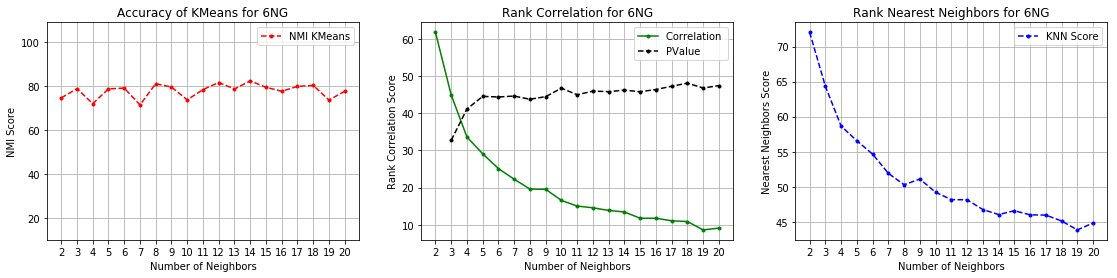




Number of original dataset dimension are: -------> 10000
Number of samples are: --------------------------> 1200
Number of embedded goal--------------------------> 100
Number of epochs are: ---------------------------> 50
Number of batch sizes are: ----------------------> 8


In [39]:
xi = [i for i in range(0, len(steps))]
plt.figure(figsize=(19,4))
plt.subplot(1,3,1)
plt.ylim(10, 109)
plt.plot(xi, NMI_step, color='r', linestyle='--', label = 'NMI KMeans', marker='.')
plt.xlabel('Number of Neighbors'),plt.ylabel('NMI Score')
plt.title('Accuracy of KMeans for {:d}NG'.format(len(categories_lables)))
plt.xticks(xi, steps)
plt.grid()
plt.legend()
plt.subplot(1,3,2)
plt.plot(xi, list_rhos, color='g', linestyle='-', label = 'Correlation ', marker='.')
plt.plot(xi, list_pvals, color='k', linestyle='--', label = 'PValue', marker='.')
plt.xlabel('Number of Neighbors'),plt.ylabel('Rank Correlation Score')
plt.title('Rank Correlation for {:d}NG'.format(len(categories_lables)))
plt.xticks(xi, steps)
plt.grid()
plt.legend()
plt.subplot(1,3,3)
plt.plot(xi, l_mean, color='b', linestyle='--', label = 'KNN Score', marker='.')
plt.xlabel('Number of Neighbors'),plt.ylabel('Nearest Neighbors Score')
plt.title('Rank Nearest Neighbors for {:d}NG'.format(len(categories_lables)))
plt.xticks(xi, steps)
plt.grid()
plt.legend()
plt.show()
print('\n\n')
print('Number of original dataset dimension are: ------->',X_train.shape[1])
print('Number of samples are: -------------------------->',n_input)
print('Number of embedded goal-------------------------->',n_code)
print('Number of epochs are: --------------------------->',epochs)
print('Number of batch sizes are: ---------------------->',n_batch)

In [0]:
top_Kbatch_NN = sorted(zip(map(lambda x: round(x, 2), l_mean), steps), reverse=True)[:10]
top_Kbatch_Corr = sorted(zip(map(lambda x: round(x, 2), list_rhos), steps), reverse=True)[:10]
top_Kbatch_NMI = sorted(zip(map(lambda x: round(x, 2), NMI_step), steps), reverse=True)[:10]

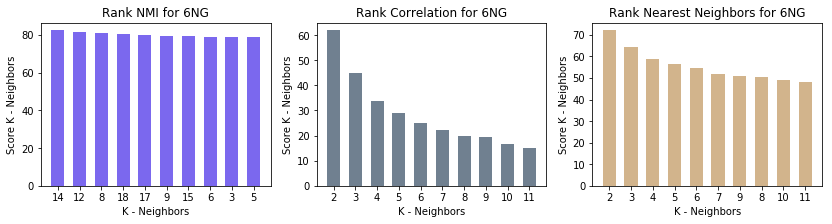

In [41]:
plt.figure(1, figsize=(14,3))
plt.subplot(1,3,1)
plt.bar(numpy.arange(len(list(zip(*top_Kbatch_NMI))[1])),
        list(zip(*top_Kbatch_NMI))[0], color='mediumslateblue', width=0.6)
plt.xticks(numpy.arange(len(list(zip(*top_Kbatch_NMI))[1])),
           list(zip(*top_Kbatch_NMI))[1]) 
plt.title('Rank NMI for {:d}NG'.format(len(categories_lables)))
plt.xlabel('K - Neighbors')
plt.ylabel('Score K - Neighbors')
plt.subplot(1,3,2)
plt.bar(numpy.arange(len(list(zip(*top_Kbatch_Corr))[1])),
        list(zip(*top_Kbatch_Corr))[0], color='slategrey', width=0.6)
plt.xticks(numpy.arange(len(list(zip(*top_Kbatch_Corr))[1])),
           list(zip(*top_Kbatch_Corr))[1]) 
plt.title('Rank Correlation for {:d}NG'.format(len(categories_lables)))
plt.xlabel('K - Neighbors')
plt.ylabel('Score K - Neighbors')
plt.subplot(1,3,3)
plt.bar(numpy.arange(len(list(zip(*top_Kbatch_NN))[1])),
        list(zip(*top_Kbatch_NN))[0], color='tan', width=0.6)
plt.xticks(numpy.arange(len(list(zip(*top_Kbatch_NN))[1])),
           list(zip(*top_Kbatch_NN))[1])
plt.title('Rank Nearest Neighbors for {:d}NG'.format(len(categories_lables)))
plt.xlabel('K - Neighbors')
plt.ylabel('Score K - Neighbors')
plt.show()